# TIME SERIES

In this notebook we first revise the main utilities of Pandas for managing time series. Afterwards, we will introduce the library *DARTS* of Python to train forecast models and predict with them.

https://unit8co.github.io/darts/


In [142]:
#current version is 0.26.0

# !pip install darts -q

## A simple example: the *Airline Passengers* dataset

In [143]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Read a pandas DataFrame
df = pd.read_csv('https://krono.act.uji.es/IDIA/airline-passengers.csv', parse_dates=['Month'], index_col='Month')

df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [144]:
## We can extract any time component from a datetime series

print('Months:', df.index.month)
print('Years:', df.index.year)

Months: Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10,
       ...
        3,  4,  5,  6,  7,  8,  9, 10, 11, 12],
      dtype='int32', name='Month', length=144)
Years: Index([1949, 1949, 1949, 1949, 1949, 1949, 1949, 1949, 1949, 1949,
       ...
       1960, 1960, 1960, 1960, 1960, 1960, 1960, 1960, 1960, 1960],
      dtype='int32', name='Month', length=144)


<Axes: xlabel='Month'>

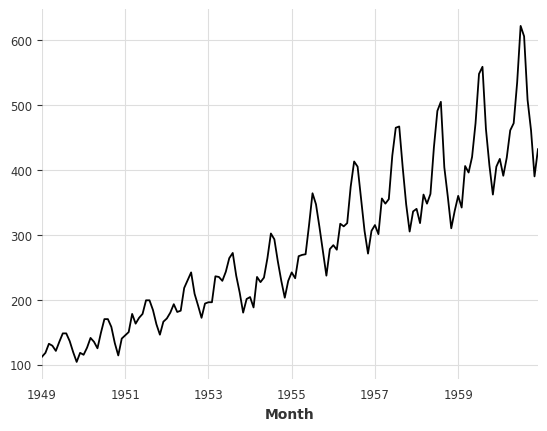

In [145]:
df['Passengers'].plot()

**Exercise 1**: Find out at which months the maximum peaks occur. Are they related to well-known periods?

In [146]:
# df.groupby months make mean

### Missing observations

If the series has missing values, we can obtain them by interpolation. Some forecasting methods are able to deal with missed observations along time (e.g., Prophet).

<Axes: xlabel='Month'>

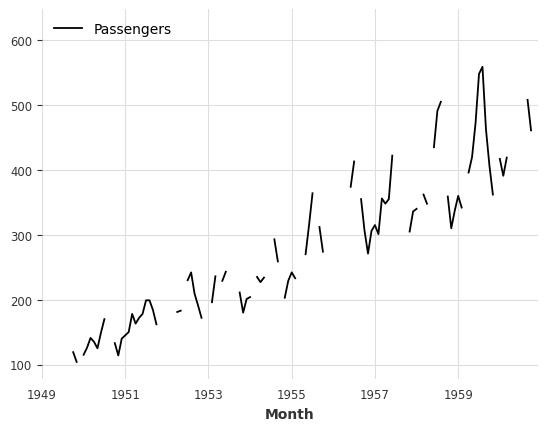

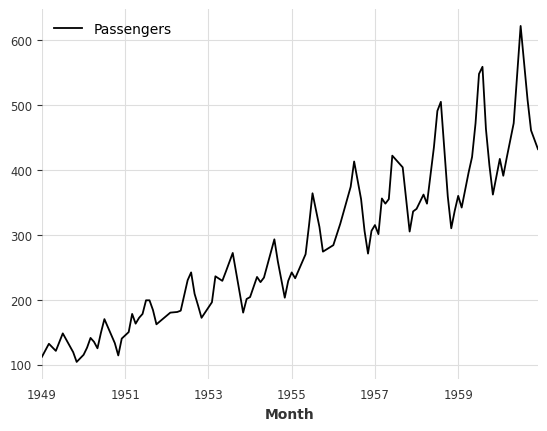

In [147]:
#sampling a
df_sampled = df.copy()

samples = df_sampled.sample(frac=0.7).index
df_sampled.loc[~df_sampled.index.isin(samples), 'Passengers'] = np.nan

df_sampled.plot()
df_sampled.interpolate(method='linear').plot() #ilinear interpolation directly in pandas

### Smoothing provides useful information

Pandas provides a good number of functions to manage time series. As an example, we can resample the series to differnt granularities (M), años (A) o días (D), and specifying periods (xG) for them. The result is the smoothing of the time series, revealing its trend.

/tmp/ipykernel_41369/1128113448.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df.resample('3M').mean().plot() # 3 months resample (M = month; A = year (annual)...)


<Axes: xlabel='Month'>

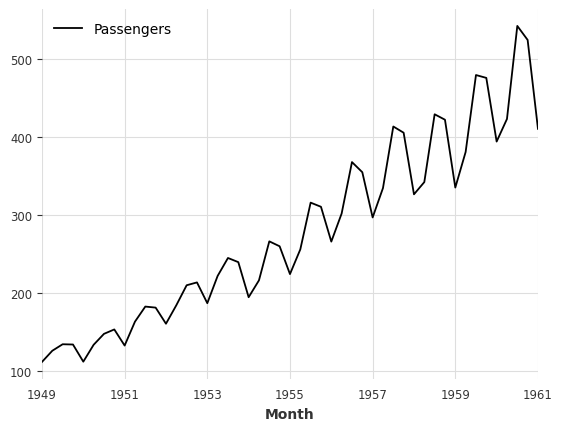

In [148]:
df.resample('3M').mean().plot() # 3 months resample (M = month; A = year (annual)...)

/tmp/ipykernel_41369/3418616396.py:1: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  df.resample('A').mean().plot() #periods of 3 months showed us that the period is 1y


<Axes: xlabel='Month'>

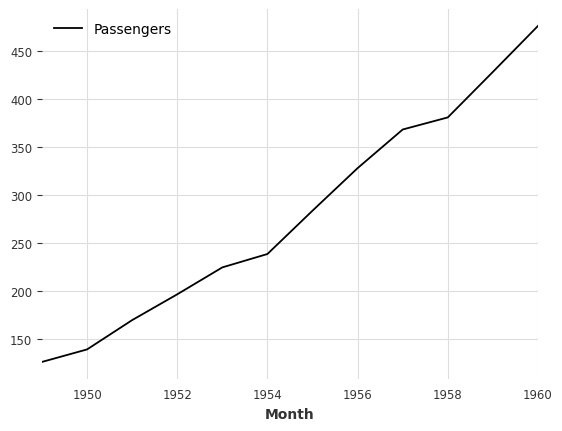

In [149]:
df.resample('A').mean().plot() #periods of 3 months showed us that the period is 1y

The moving average (MA) can smooth the time series to reduce the effect of seasons and noise. Here, *window* is the size of the moving window for performing the **convolution** of the time series. The argument *min_periods* sets the minimum number of observations that must be within the window to perform the average.

<Axes: xlabel='Month'>

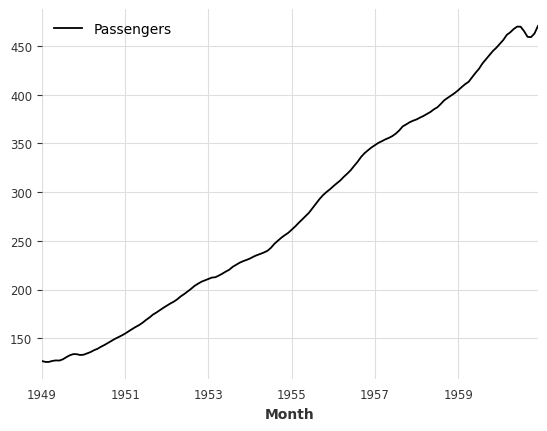

In [150]:
df.rolling(window=24, center=True, min_periods=1).mean().plot()

**Question 1**: Pleae, answer to the following questions:

- What is the trend of this series?
- Is it stationary?
- Does it exhibit seasonality? If so, what kind?
- Is it additive?

The series is not stationary; the average grows with time
The series exhibits seasonality, as we could see while performing the mean; it exhibits a peak during easter and another smaller one durng thanks-giving
It appears to be multiplicative, more than additive, the amplitude of its carrying period grows with time aswell
About the trend, we can say it is positive and it grows, judging by eye, about 31.2 passengers per year

## Decomposition of the time series
* Trend
* Cycles
* Seasons
* White noise

In [151]:
#import numpy as np

x = df.reset_index().index.to_numpy()

p1, res1, _, _ , _ = np.polyfit(x, df['Passengers'], 1, full=True)
p1_fn = np.poly1d(p1)

p2, res2, _, _ , _ = np.polyfit(x, df['Passengers'], 2, full=True)
p2_fn = np.poly1d(p2)

print("Trend (linear):", p1, res1)
print("Trend (quadratic):", p2, res2)

Trend (linear): [ 2.65718391 90.30996169] [301219.11848659]
Trend (quadratic): [7.00819832e-03 1.65501155e+00 1.14028041e+02] [284328.40508941]


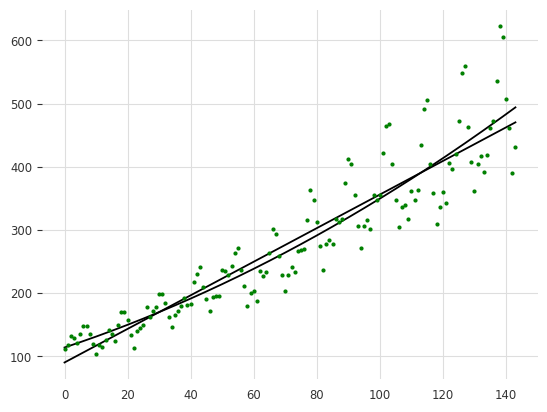

In [152]:
plt.plot(x, p2_fn(x), 'k-')
plt.plot(x, p1_fn(x), 'k-')
plt.plot(x, df['Passengers'], 'go', ms=2)

Auto-correlación: 0.9601946480498523


<Axes: xlabel='Lag', ylabel='Autocorrelation'>

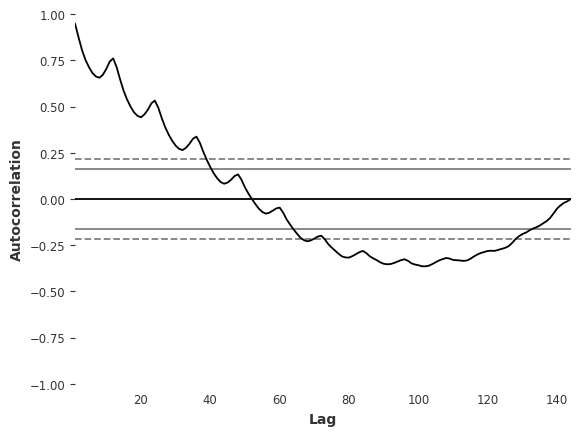

In [153]:
from pandas.plotting import autocorrelation_plot

print('Auto-correlación:', df['Passengers'].autocorr())

autocorrelation_plot(df) ##ACF

**Question 2**: What insights can you draw from this plot?

***ANSWER***
- The graph starting at a very high value and taking a lot of time to cross the "noise region" indicates that the series is not stationary
- The point where it first crosses the .25 threshold, is the maximum correlation; the series autocorrelates up to 40months (abt. 3 years)
- Somehow, from 70 months on, the series autocorrelates inversely 

## NORMALIZING TIME SERIES

There are different ways to get a stationary time series from a non-stationary one. We here revise the most applied ones.

### Method 1: Log of the time series minus rolling mean

Goal: de-trend (by substracting the rolling mean) and eliminate the "multiplicative" effect of the original series (by applying log).

/tmp/ipykernel_41369/2580462853.py:9: FutureWarning: The 'fill_method' keyword being not None and the 'limit' keyword in DataFrame.pct_change are deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df_log_minus_mean.pct_change(fill_method='ffill').plot()


<Axes: xlabel='Month'>

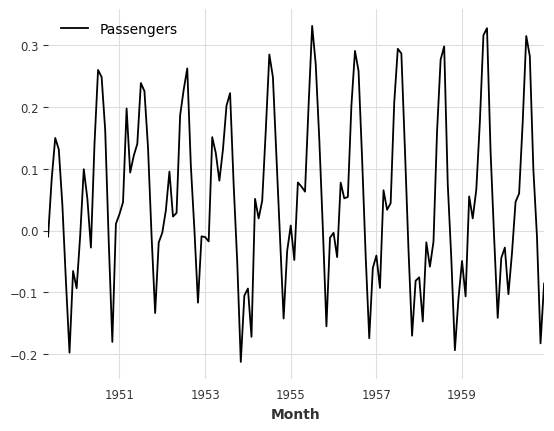

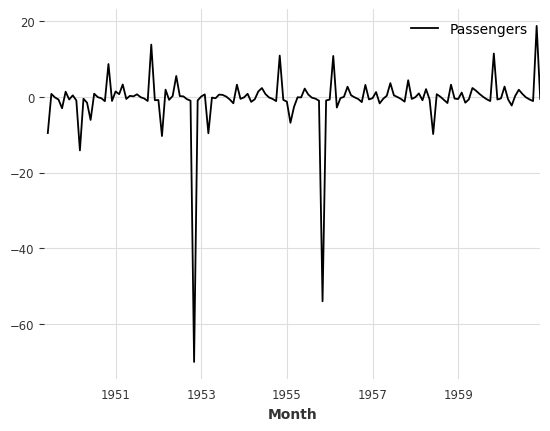

In [154]:
df_log = np.log(df)

#restamos la "rolling mean"
rolling_mean = df_log.rolling(window=12, min_periods=5).mean()
df_log_minus_mean = df_log - rolling_mean
df_log_minus_mean.dropna(inplace=True)

df_log_minus_mean.plot()
df_log_minus_mean.pct_change(fill_method='ffill').plot()

**Question 3**: How does the normalized series behave with respect to the autocorrelation plot?

What differences do you identify between the normalized and non-normalized series?

***ANSWER***

- Each peak corresponds to one period of the series, and from some point on, the autocorrelation is no longer: the former negative autocorrelation was not a real one, it somehow came from the slope

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

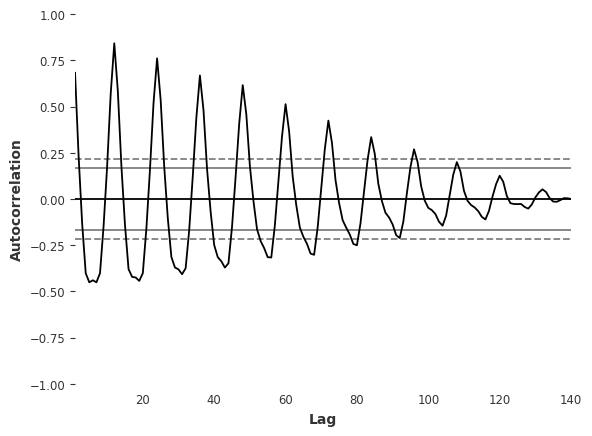

In [155]:
autocorrelation_plot(df_log_minus_mean) ##ACF

### Method 2. Exponential smoothing

Goal: like Method 1 but the moving average is calculated with exponential decay.



<Axes: xlabel='Month'>

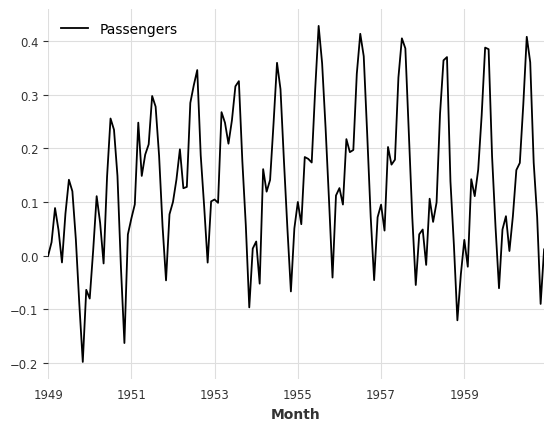

In [156]:
#df_log = np.log(df)

rolling_mean_exp_decay = df_log.ewm(halflife=12, min_periods=0, adjust=True).mean()
df_log_exp_decay = df_log - rolling_mean_exp_decay
df_log_exp_decay.dropna(inplace=True)

df_log_exp_decay.plot()

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

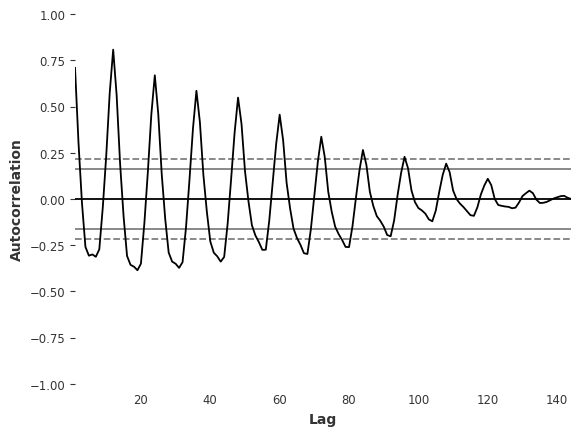

In [157]:
autocorrelation_plot(df_log_exp_decay) ##ACF

### Method 3: Differentiation

Goal: apply the differenation of the series to reduce the seasonability effect.

<Axes: xlabel='Month'>

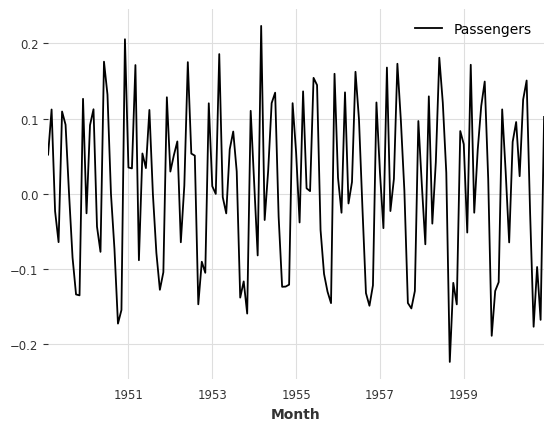

In [158]:
#df_log = np.log(df.set_index('Month'))

df_log_shift = df_log.diff()
df_log_shift.dropna(inplace=True)

df_log_shift.plot()

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

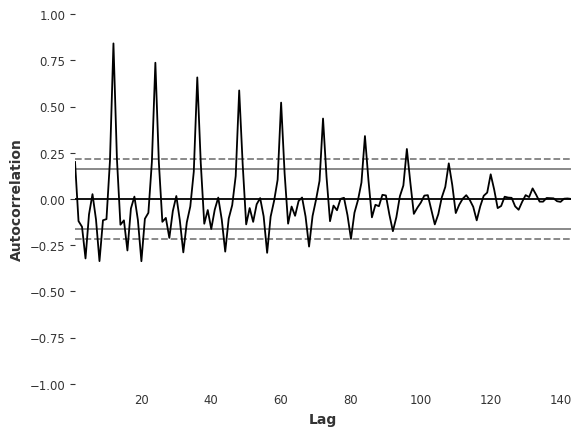

In [159]:
autocorrelation_plot(df_log_shift) ##ACF

**Question 4**: Which of these normalization methods do you think is the most suitable for prediction?

<mark>ANSWER</mark>

### **Reversing the transformations**

This is necessary to adjust predictions in normalized series.

<Axes: xlabel='Month'>

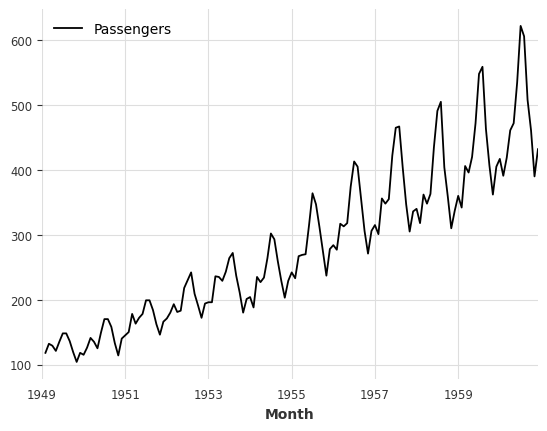

In [160]:
#The Inverse

df_inv = np.exp(df_log.shift() + df_log_shift)

df_inv.plot()

In the DARTS library, you can find additional transformers and their inverses to enhance forecasting. The following link provides examples of normalizations along with their inverses (to revert the predicted values back to the original time series scale):

https://unit8co.github.io/darts/examples/02-data-processing.html

## Frequency Analysis with Fast Fourier Transform

Which are the dominant frequencies in a time series? Which cycles the time series contain?

(We use for this part the library **scipy**)

In [161]:
import scipy as sp
import scipy.fftpack

series = df['Passengers']

temp_fft = sp.fftpack.fft(series) #_log_minus_mean)
temp_psd = np.abs(temp_fft) ** 2


In [162]:
freq_unit = 1/12 #months in a year

fftfreq = sp.fftpack.fftfreq(len(temp_psd), freq_unit)

i = fftfreq > 0

In [163]:
1./fftfreq[i]

array([12.        ,  6.        ,  4.        ,  3.        ,  2.4       ,
        2.        ,  1.71428571,  1.5       ,  1.33333333,  1.2       ,
        1.09090909,  1.        ,  0.92307692,  0.85714286,  0.8       ,
        0.75      ,  0.70588235,  0.66666667,  0.63157895,  0.6       ,
        0.57142857,  0.54545455,  0.52173913,  0.5       ,  0.48      ,
        0.46153846,  0.44444444,  0.42857143,  0.4137931 ,  0.4       ,
        0.38709677,  0.375     ,  0.36363636,  0.35294118,  0.34285714,
        0.33333333,  0.32432432,  0.31578947,  0.30769231,  0.3       ,
        0.29268293,  0.28571429,  0.27906977,  0.27272727,  0.26666667,
        0.26086957,  0.25531915,  0.25      ,  0.24489796,  0.24      ,
        0.23529412,  0.23076923,  0.22641509,  0.22222222,  0.21818182,
        0.21428571,  0.21052632,  0.20689655,  0.20338983,  0.2       ,
        0.19672131,  0.19354839,  0.19047619,  0.1875    ,  0.18461538,
        0.18181818,  0.17910448,  0.17647059,  0.17391304,  0.17

Text(0, 0.5, 'PSD')

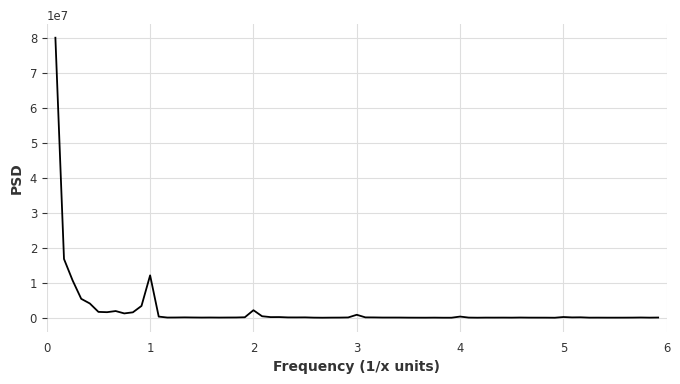

In [164]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(fftfreq[i], temp_psd[i])
ax.set_xlim(0, 6)
ax.set_xlabel('Frequency (1/x units)')
ax.set_ylabel('PSD')

**Question 5**: Which insights can you draw from the previous plot? which are the cycles present in the time series?

**Exercise 2:** Perform the same frequency analysis over a normalized time series.


## TRAINING AND PREDICTING WITH FORECAST MODELS

We will first use a simple model named *Exponential Smoothing*

https://towardsdatascience.com/holt-winters-exponential-smoothing-d703072c0572


In [165]:
# !pip install dask[dataframe] -q

In [166]:
from darts import TimeSeries
from darts.models import ExponentialSmoothing

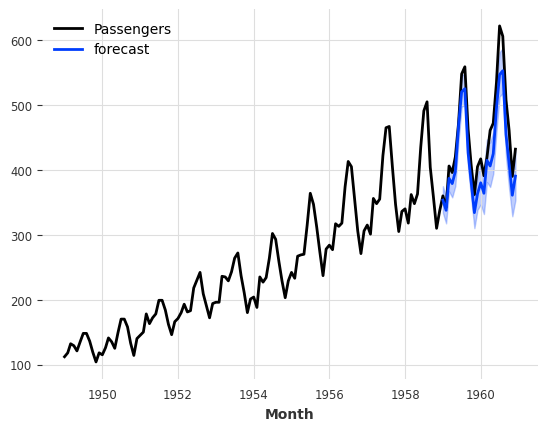

In [167]:
# Create a TimeSeries, specifying the time and value columns (it can be a list)

df_darts = df.reset_index()

series = TimeSeries.from_dataframe(df_darts, time_col='Month', value_cols='Passengers')

# Split the series into train and validation (you can use the utility train_test_split from DARTS)

cut = -24

train, val = series[:cut], series[cut:]

# Build and train the model

model = ExponentialSmoothing()

model.fit(train)
prediction = model.predict(len(val), num_samples=1000)

# Visualize the prediction

series.plot()
prediction.plot(label='forecast', low_quantile=0.05, high_quantile=0.95)
plt.legend()

### The `TimeSeries` object

Prediction is an object of the class `TimeSeries`

https://unit8co.github.io/darts/generated_api/darts.timeseries.html

Values of the predicted time series are stored in a special array with the following components: *(time, dimensions, samples)*

Dimensions are the time serires that we included in the `value_cols` argument (it can be a list)

Predictions can be "stochastic" if it is a random process that generates a number of samples, or "deterministic" if the result is just one time series.

Implementation has been done with Xarrays: https://xarray.pydata.org/en/stable/generated/xarray.DataArray.html

In [168]:
prediction

<TimeSeries (DataArray) (Month: 24, component: 1, sample: 1000)> Size: 192kB
array([[[376.18304431, 359.1662491 , 366.38497898, ..., 355.34884259,
         339.85534098, 349.70558985]],

       [[349.72126483, 349.89043357, 335.19562019, ..., 339.82818681,
         319.93574726, 320.15874772]],

       [[375.50279329, 370.23366841, 389.99389392, ..., 386.12022438,
         365.88245109, 381.83787588]],

       ...,

       [[434.86711459, 381.75571073, 435.03093766, ..., 433.52967208,
         407.92000823, 407.8565263 ]],

       [[371.45525278, 326.15955391, 395.91281934, ..., 367.98739597,
         369.69719823, 361.64328481]],

       [[413.40764187, 346.53085216, 391.06030228, ..., 382.7778308 ,
         396.20680813, 383.08054372]]])
Coordinates:
  * Month      (Month) datetime64[ns] 192B 1959-01-01 1959-02-01 ... 1960-12-01
  * component  (component) object 8B 'Passengers'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

To get one of the samples from the prediction, we must indicate the time slice, component and position of the sample starting in 0.

In [169]:
prediction.all_values()[:,0,50]

array([343.0012495 , 325.94530056, 359.82694687, 373.2899944 ,
       366.23346658, 465.47758495, 506.26400802, 531.8057299 ,
       451.38078065, 384.2808553 , 344.1839752 , 346.41151814,
       394.33752287, 391.58462493, 412.94842361, 425.84989712,
       430.1088052 , 538.30400456, 552.43813636, 589.51244438,
       509.82513761, 443.67078029, 385.63251674, 398.24516369])

We can also extract one series representing the predicted samples, like the median:

<Axes: xlabel='Month'>

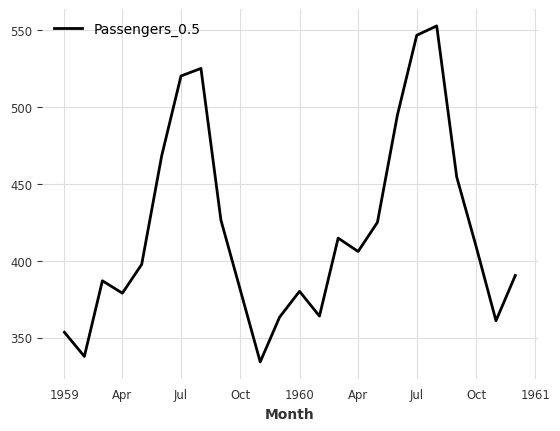

In [170]:
prediction.quantile_timeseries(0.5).plot()

The extracted series can be then processed by converting it to a Pandas series as follows:

In [171]:
prediction.quantile_timeseries(0.5).pd_series()

Month
1959-01-01    353.449648
1959-02-01    337.723937
1959-03-01    386.985532
1959-04-01    378.906040
1959-05-01    397.660083
1959-06-01    468.291527
1959-07-01    520.343712
1959-08-01    525.271983
1959-09-01    426.523312
1959-10-01    381.134989
1959-11-01    334.139461
1959-12-01    363.235122
1960-01-01    380.134627
1960-02-01    363.989081
1960-03-01    414.777841
1960-04-01    406.058540
1960-05-01    425.072958
1960-06-01    494.918736
1960-07-01    546.856728
1960-08-01    552.953399
1960-09-01    454.676863
1960-10-01    409.595675
1960-11-01    360.962335
1960-12-01    390.426286
Freq: MS, Name: Passengers_0.5, dtype: float64

You can also convert the extracted series to a Pandas dataframe:

In [172]:
prediction.quantile_timeseries().pd_dataframe()

component,Passengers_0.5
Month,
1959-01-01,353.449648
1959-02-01,337.723937
1959-03-01,386.985532
1959-04-01,378.906040
1959-05-01,397.660083
1959-06-01,468.291527
1959-07-01,520.343712
1959-08-01,525.271983
1959-09-01,426.523312


**Exercise 3**: Extract the upper and lower series for representing the confidence interval with 0.9 confidence, and then plot them.

<Axes: xlabel='Month'>

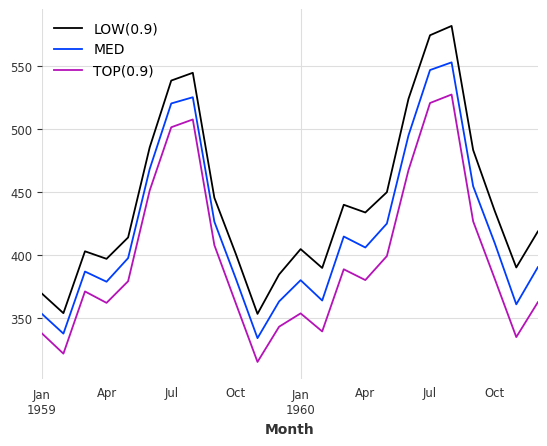

In [173]:
table = pd.DataFrame()
table["LOW(0.9)"] = prediction.quantile_timeseries(0.9).pd_dataframe()
table["MED"] = prediction.quantile_timeseries().pd_dataframe()
table["TOP(0.9)"] = prediction.quantile_timeseries(0.1).pd_dataframe()

table.plot()

### RESIDUALS ANALYSIS

Be patient! this operation is quite time consuming.

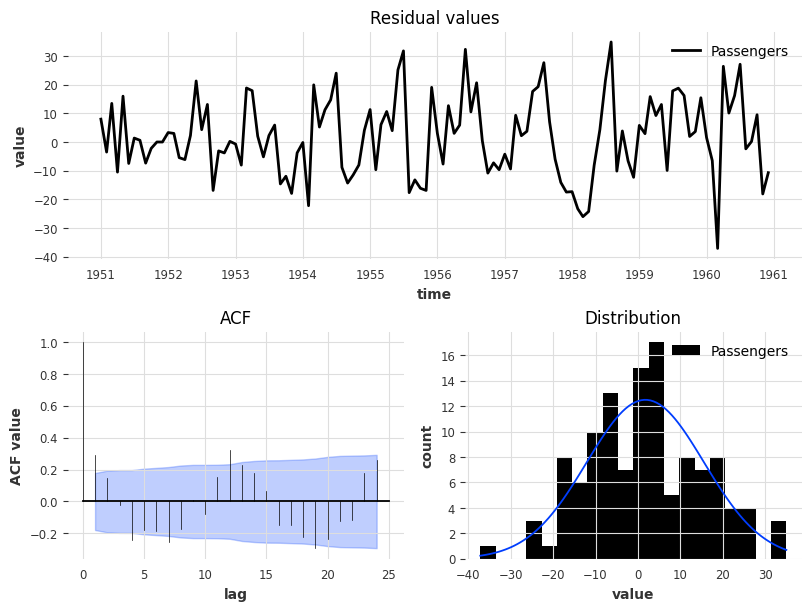

In [174]:
from darts.utils.statistics import *

residuals = model.residuals(series)

plot_residuals_analysis(residuals)

**Question 6**: Which insights can you draw from these plots?

### EVALUATE THE MODEL

DARTS provides us a good number of metrics to evaluate the prediction.

https://unit8co.github.io/darts/generated_api/darts.metrics.metrics.html

In [175]:
from darts.metrics import mape, rmse

In [176]:
print('MAPE = ', mape(val, prediction))
print("RMSE = ", rmse(val, prediction))

MAPE =  6.964840770132564
RMSE =  37.13811336724038


In [177]:
from darts.models import Prophet

We train and evaluate a PROPHET model.

In [178]:
model2 = Prophet()
model2.fit(train)
prediction = model2.predict(len(val), num_samples=1000)


series.plot()
prediction.plot(label='forecast', low_quantile=0.05, high_quantile=0.95)
plt.legend()


ImportError: The `Prophet` module could not be imported. To enable Prophet support in Darts, follow the detailed instructions in the installation guide: https://github.com/unit8co/darts/blob/master/INSTALL.md


ImportError: The `Prophet` module could not be imported. To enable Prophet support in Darts, follow the detailed instructions in the installation guide: https://github.com/unit8co/darts/blob/master/INSTALL.md

In [ ]:
print('MAPE = ', mape(val, prediction))
print("RMSE = ", rmse(val, prediction))

MAPE =  6.53837852458415
RMSE =  40.44151688059339


**Question 7**: Which model perform best according to the evaluation metrics?

## Anomaly detection

In [185]:
import darts.ad.detectors.quantile_detector as qad

Anomaly = qad.QuantileDetector(low_quantile=0.05, high_quantile=0.95)

Anomaly.fit(train)

anom = Anomaly.detect(val).pd_series()
anom

Month
1959-01-01    0.0
1959-02-01    0.0
1959-03-01    0.0
1959-04-01    0.0
1959-05-01    1.0
1959-06-01    1.0
1959-07-01    1.0
1959-08-01    1.0
1959-09-01    1.0
1959-10-01    0.0
1959-11-01    0.0
1959-12-01    0.0
1960-01-01    1.0
1960-02-01    0.0
1960-03-01    1.0
1960-04-01    1.0
1960-05-01    1.0
1960-06-01    1.0
1960-07-01    1.0
1960-08-01    1.0
1960-09-01    1.0
1960-10-01    1.0
1960-11-01    0.0
1960-12-01    1.0
Freq: MS, Name: Passengers, dtype: float64

In [180]:
print("Anomalies detected:", Anomaly.fit_detect(series).pd_series().sum())

Anomalies detected: 16.0


In [181]:
norm_series = TimeSeries.from_dataframe(df_log_minus_mean.reset_index(), time_col='Month', value_cols='Passengers')

print("Anomalies detected:", Anomaly.fit_detect(norm_series).pd_series().sum())

Anomalies detected: 14.0


**Exercise 4**: Please, plot the time series and the detected anomalies with red dots.

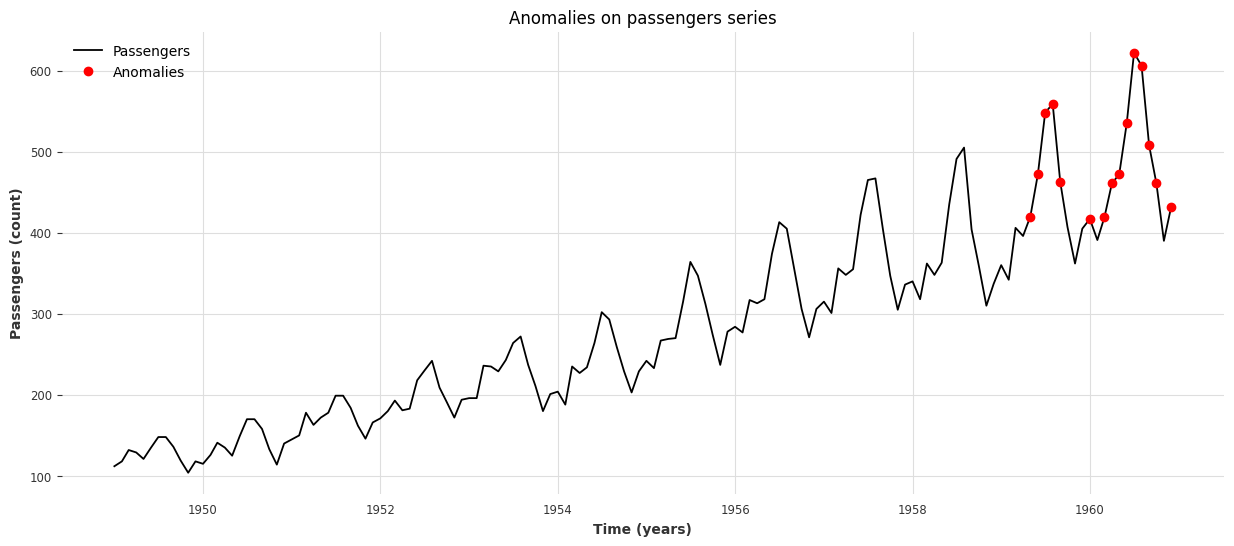

In [225]:
series_pd = series.pd_dataframe()
series_pd = series_pd.merge(Anomaly.detect(val).pd_series(), left_index=True, right_index=True, suffixes=["_count", "_anomaly"])
series_pd.fillna(0)

# get x and y coordinates for aberrations
scatter = series_pd[series_pd["Passengers_anomaly"] > 0.5]["Passengers_count"]

plt.figure(figsize=(15,6))
plt.plot(series.pd_dataframe(), label="Passengers")
plt.plot(scatter, "ro", label = "Anomalies") # plot anomalies as red dots
plt.title("Anomalies on passengers series")
plt.legend()
plt.xlabel("Time (years)")
plt.ylabel("Passengers (count)")
plt.show()
